In [79]:
%reload_ext autoreload
import numpy as np
import pandas as pd


# import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats

# import own scripts
import sys
sys.path.insert(0, '/src/')

%autoreload 2
from utils import plot_multi, norm_dist_test, Model, clean_ff, test_stationarity, decompose_trend,grid_search_SARIMA

In [75]:
# load data
ff = clean_ff(pd.read_csv('data/FEDFUNDS.csv'))

In [ ]:
ff['rolmean'] = ff['FedFundsRate'].rolling(12).mean()
ff['rolstd'] = ff['FedFundsRate'].rolling(12).std()

In [84]:
ff.head()

,FedFundsRate,rolmean,rolstd
Date,,,
1954-07-01,0.80,NaN,NaN
1954-08-01,1.22,NaN,NaN
1954-09-01,1.06,NaN,NaN
1954-10-01,0.85,NaN,NaN
1954-11-01,0.83,NaN,NaN


In [121]:
from bokeh.io import output_notebook, show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure
output_notebook()

def bk_window_plot(df, label):
    dates = np.array(ff.index, dtype=np.datetime64)
    source = ColumnDataSource(data=dict(date=dates, rate=ff[label]))

    p = figure(plot_height=400, plot_width=900, tools="", toolbar_location=None,
               x_axis_type="datetime", x_range=(dates[648], dates[768]))

    p.line('date', 'rate', source=source)
    p.yaxis.axis_label = label

    select = figure(plot_height=200, plot_width=900, y_range=p.y_range,
                    x_axis_type="datetime", y_axis_type=None,
                    tools="", toolbar_location=None)

    range_rool = RangeTool(x_range=p.x_range)
    range_rool.overlay.fill_color = "navy"
    range_rool.overlay.fill_alpha = 0.2

    select.line('date', 'rate', source=source)
    select.ygrid.grid_line_color = None
    select.add_tools(range_rool)
    select.toolbar.active_multi = range_rool
    show(column(p, select))
    
bk_window_plot(ff, 'FedFundsRate')

Loading BokehJS ...

## Achieve stationarity
---
Define Stationarity:
1. Constant mean, 
2. Constant variance, 
3. Autocovariance that does not depend on time

Use `Dickey-Fuller Test`: This is one of the statistical tests for checking stationarity. Here the **null hypothesis is that the TS is non-stationary**. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

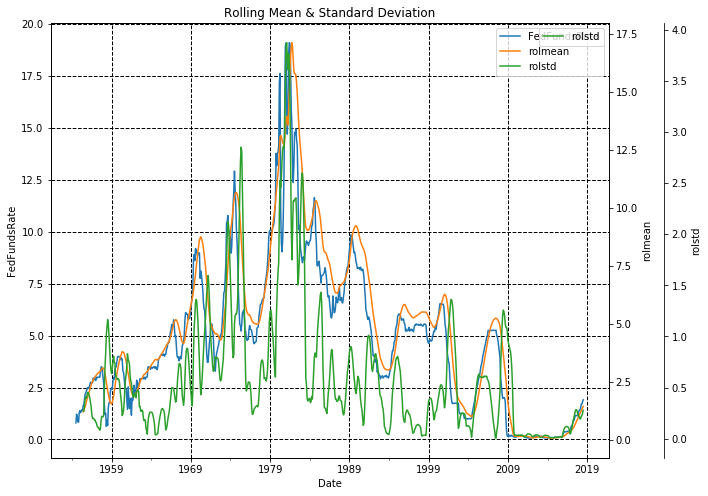

Results of Dickey-Fuller Test:
Test Statistic                  -2.765412
p-value                          0.063387
#Lags Used                      17.000000
Number of Observations Used    751.000000
Critical Value (1%)             -3.439087
Critical Value (5%)             -2.865396
Critical Value (10%)            -2.568823
dtype: float64


In [7]:
test_stationarity(ff, 'FedFundsRate',12)

> Although, p-value is close to 0.05, it's still clear that the `Fed Funds` data is not stationary because `Rolling Std` is also NOT constant.

We can proceed with using `Seasonal Decomposition`. This is a quick and common practice to assess if time series data has a underlying seasonality. The default parameters used here generate a trend.

## Analyze Seasonal Decomposition of Fed Funds Data
---
> **additive**: y(t) = Level + Trend + Seasonality + Noise <br>
> **multiplicative**:  y(t) = Level x Trend x Seasonality x Noise <br>
> **Decision**: `additive` makes more sense becasue `FedFunds` is range bound... but let's see the residual noise.

Dickey–Fuller test: p=0.063387


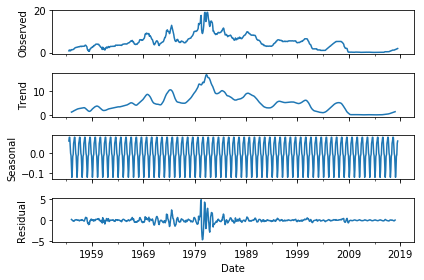

In [8]:
decompose_trend(ff, 'FedFundsRate', model='additive')

Dickey–Fuller test: p=0.063387


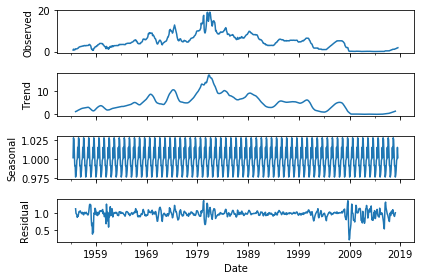

In [9]:
decompose_trend(ff, 'FedFundsRate', model='multiplicative')

## Box-Cox Power Transformation:
In statistics, a power transform is a family of functions that are applied to create a monotonic transformation of data using power functions. This is a useful data transformation technique used to stabilize variance, make the data more normal distribution-like, improve the validity of measures of association such as the Pearson correlation between variables and for other data stabilization procedures.

Dickey–Fuller test: p=0.160915


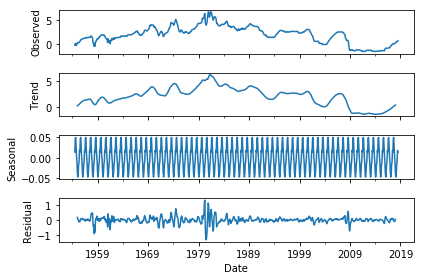

In [10]:
ff['box_cox'], _ = stats.boxcox(ff['FedFundsRate'])
decompose_trend(ff, 'box_cox', model='additive')

> p-value went up to 0.16 when applying Box-Cox Transformation. Therefore, applying the power transformation did not produce stationarity in data.

In [11]:
ff_sarima_model = grid_search_SARIMA(ff['FedFundsRate'])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1036.246, BIC=1059.386, Fit time=3.998 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1739.227, BIC=1748.483, Fit time=0.145 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1348.024, BIC=1366.536, Fit time=1.088 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1035.419, BIC=1053.931, Fit time=3.326 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1025.514, BIC=1048.654, Fit time=3.485 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=1322.048, BIC=1340.561, Fit time=1.219 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=1027.517, BIC=1055.285, Fit time=18.671 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1605.633, BIC=1619.517, Fit time=0.298 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=1029.043, BIC=1061.439, Fit time=16.263 seconds
Fit ARIMA: order=(1, 1, 1)

Dickey–Fuller test: p=0.049679


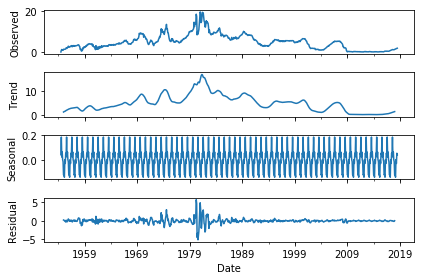

In [12]:
ff['SARIMA'] = ff_sarima_model.predict_in_sample()
decompose_trend(ff, 'SARIMA', model='additive')

**Achieved Stationarity with SARIMA grid search!** May use ff_SARIMA predictions as an exogenous feature in forecasting GDP.

In [10]:
# save
ff.to_csv('src/results/ff.csv', sep=',')